# Dataset Statistics

In [11]:
# - basic python utils
import gc
import json
import os
import time
# import random
# import re
from collections import Counter, defaultdict
from tqdm import tqdm
from typing import Optional

# - data processing
import math
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("rose-pine-dawn")
import scipy.stats

# - nlp
from transformers import AutoTokenizer

In [8]:
def filter_dataset(
    data_dir: str = "../data/",
    lean_dojo_split: str = "random",
    split: str = "train",
    tokenizer_id: str = "EleutherAI/llemma_7b",
    min_depth: int = 1,
    max_depth: int = 3,
    token_limit: Optional[int] = None,
) -> tuple[list[int], list[int]]:
    """
    - creates a data subset with proofs of a maximum depth of `max_depth`.
    - saves the dataset to the provided path
    - gathers statistics about tactic token lengths
    """
    train_data_path = os.path.join(
        data_dir,
        "leandojo_benchmark_4",
        lean_dojo_split,
        f"{split}.json",
    )
    start = time.perf_counter()
    with open(train_data_path, "r") as f:
        train_data = json.load(f)
    print(f"Loaded {len(train_data)} proofs in {time.perf_counter() - start:.2f} seconds")
    
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)

    filtered = []
    proof_lengths = []
    tactic_lengths = []
    token_limit = token_limit or math.inf
    
    print("Filtering proofs...")
    for proof in tqdm(train_data, total=len(train_data)):
        proof_length = len(proof["traced_tactics"])
        proof_lengths.append(proof_length)
        if not (min_depth <= proof_length <= max_depth):
            continue

        token_filter_status = True
        for traced_tactic in proof["traced_tactics"]:
            tactic = traced_tactic["tactic"]
            token_length = len(tokenizer.encode(tactic))
            tactic_lengths.append(token_length)
            if token_length > token_limit:
                token_filter_status = False

        if token_filter_status:
            filtered.append(proof)
    
    # save the filtered data
    filename = f"{lean_dojo_split}_{split}_md{max_depth}_tl{token_limit}.json"
    output_path = os.path.join(data_dir, filename)
    start = time.perf_counter()
    with open(output_path, "w") as f:
        json.dump(filtered, f, indent=2)
    print(f"Saved {len(filtered)} proofs in {time.perf_counter() - start:.2f} seconds")
    
    return proof_lengths, tactic_lengths

In [7]:
pls, tls = filter_dataset()

Loaded 112729 proofs in 5.75 seconds


100%|██████████| 112729/112729 [00:04<00:00, 25538.87it/s]


Saved 37949 proofs in 3.61 seconds


In [9]:
_, _ = filter_dataset(min_depth=0)

Loaded 112729 proofs in 5.92 seconds
Filtering proofs...


100%|██████████| 112729/112729 [00:04<00:00, 24676.24it/s]


Saved 94538 proofs in 4.64 seconds


In [10]:
npls, ntls = filter_dataset(
    lean_dojo_split="novel_premises", 
)

Loaded 112729 proofs in 5.59 seconds
Filtering proofs...


100%|██████████| 112729/112729 [00:04<00:00, 25691.94it/s]


Saved 38042 proofs in 3.58 seconds


In [12]:
def summary_statistics(data: list[int]):
    # print statistics: min, max, median, quartiles
    data_ = sorted(data)
    print(
        f"mean: {np.mean(data_):.2f}\n"
        f"min: {data_[0]}\n"
        f"25th percentile: {np.percentile(data_, 25):.2f}\n"
        f"median: {np.median(data_):.2f}\n"
        f"75th percentile: {np.percentile(data_, 75):.2f}\n"
        f"max: {data_[-1]}"
    )

In [14]:
def deciles(data):
    for i in range(0, 100, 10):
        print(f"{i}th percentile: {np.percentile(data, i):.2f}")

In [13]:
summary_statistics(npls)

mean: 2.07
min: 0
25th percentile: 0.00
median: 0.00
75th percentile: 2.00
max: 128


In [15]:
deciles(npls)

0th percentile: 0.00
10th percentile: 0.00
20th percentile: 0.00
30th percentile: 0.00
40th percentile: 0.00
50th percentile: 0.00
60th percentile: 1.00
70th percentile: 2.00
80th percentile: 3.00
90th percentile: 6.00


In [16]:
summary_statistics(ntls)
deciles(ntls)

mean: 20.04
min: 2
25th percentile: 8.00
median: 16.00
75th percentile: 27.00
max: 274
0th percentile: 2.00
10th percentile: 3.00
20th percentile: 6.00
30th percentile: 10.00
40th percentile: 13.00
50th percentile: 16.00
60th percentile: 20.00
70th percentile: 24.00
80th percentile: 30.00
90th percentile: 40.00


In [17]:
pu32t, tu32t = filter_dataset(lean_dojo_split="novel_premises", token_limit=32)

Loaded 112729 proofs in 5.75 seconds
Filtering proofs...


100%|██████████| 112729/112729 [00:04<00:00, 24907.66it/s]


Saved 28800 proofs in 2.24 seconds


In [18]:
print("proof lengths")
summary_statistics(pu32t)
deciles(pu32t)
print("tactic lengths")
summary_statistics(tu32t)
deciles(tu32t)

proof lengths
mean: 2.07
min: 0
25th percentile: 0.00
median: 0.00
75th percentile: 2.00
max: 128
0th percentile: 0.00
10th percentile: 0.00
20th percentile: 0.00
30th percentile: 0.00
40th percentile: 0.00
50th percentile: 0.00
60th percentile: 1.00
70th percentile: 2.00
80th percentile: 3.00
90th percentile: 6.00
tactic lengths
mean: 20.04
min: 2
25th percentile: 8.00
median: 16.00
75th percentile: 27.00
max: 274
0th percentile: 2.00
10th percentile: 3.00
20th percentile: 6.00
30th percentile: 10.00
40th percentile: 13.00
50th percentile: 16.00
60th percentile: 20.00
70th percentile: 24.00
80th percentile: 30.00
90th percentile: 40.00


## Plotting

In [28]:
def make_hist(data, label, file=None, bounds=None):
    bin_count = len(set(data))
    plt.hist(data, bins=bin_count, range=bounds)
    plt.title(label)
    plt.ylabel("frequency")
    if bounds:
        # plt.xticks(range(bounds[1] + 1))
        pass
    if file:
        plt.savefig(file)
    plt.show()

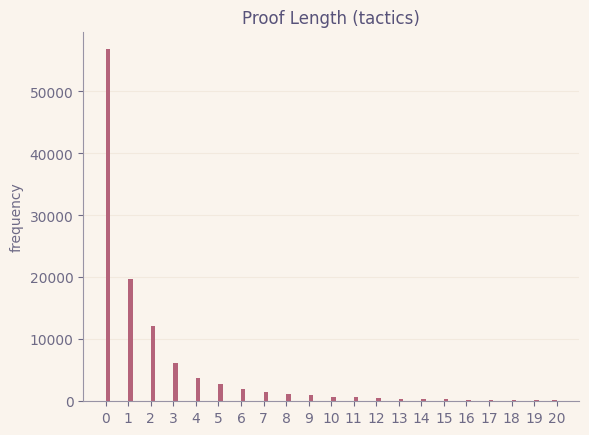

In [26]:
make_hist(pu32t, "Proof Length (tactics)", "proof_lengths_hist.png", bounds=(0, 20))

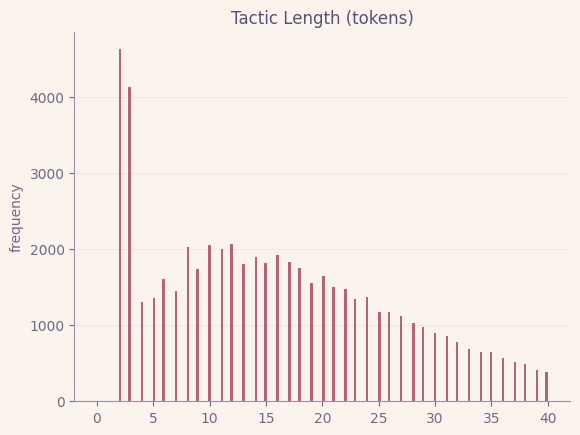

In [30]:
make_hist(tu32t, "Tactic Length (tokens)", "tactic_lengths_hist.png", bounds=(0, 40))